<h2>Introduction</h2>

In this post we're going to look at applying a class of simple unsupervised machine learning algorithms called clustering. Specifically we're going to be looking at two types of clustering apporaches called Hierarchical Agglomerative Clustering and K-Means Clustering using the Scikit-learn framework in Python. The dataset that we're going to analyze contains demand data for a large number of Part Numbers belonging to several product families. The intent is to see how we can use the nature of the demand as a feature to help us create product families.


<h2>Import Libraries</h2>

In [1]:
'''libraries for data wrangling'''
import math
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

'''ML libraries for clustering work'''
import scipy.cluster.hierarchy as sch
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, classification_report

<h2>Data Wrangling and Exploratory Analysis</h2>

Download the data from this link <a href= 'https://github.com/adikamath/datasets/blob/master/sku_data.xlsx'>here</a>. The data that we have here is in the pivoted form which isn't very helpful when you want to run algorithms on it. So lets clean and transform the dataset. Some of the ways we will be cleaning the dataset is by unpivoting the dataset, convert the date into timestamp format, extract and store elements of the data (this will be helpful during time series analysis). I will also be aggregating the demand for each Part Number by month of the year.

In [2]:
'''read in the dataset'''
data= pd.read_excel(r'sku_data.xlsx')

In [3]:
'''prepare to melt the data and get the dates in the headers as values into the month column'''
'''create the list of header names'''
cols= list(data.columns)

'''melt the dataset, id_vars is the columns to keep while the value_vars is the list of headers that need to be 
converted to values'''
sku_melted= pd.melt(data, id_vars= cols[:2], value_vars= cols[3:], var_name= 'date')

In [4]:
'''extract a month and year from the date column'''
sku_melted['month']= sku_melted['date'].apply(lambda x: str(x.strftime('%b'))+'-'+str(x.year))

In [5]:
'''good practice to store the date in timestamp format'''
sku_melted['month']= pd.to_datetime(sku_melted['month'])

In [6]:
sku_melted.to_excel(r'sku_melted.xlsx', index= False)

In [7]:
'''ensure that for each part number you aggregate the demand data by month'''
toCluster= pd.DataFrame(sku_melted.groupby(['Part Number', 'month'])['value'].sum()).reset_index()

'''convert all the months to datetime format'''
toCluster['month']= pd.to_datetime(toCluster['month'])

In [8]:
toCluster.head()

,Part Number,month,value
0,PN-100-430,2014-06-01,0
1,PN-100-430,2014-07-01,0
2,PN-100-430,2014-08-01,0
3,PN-100-430,2014-09-01,0
4,PN-100-430,2014-10-01,0


An interesting approach that I recently came across when exploring ways to segment SKUs was to plot the average demand for each SKU against the coeficient of variance. Coeficient of Variance (COV) is a measure of volatility of data and is the ratio of the standard deviation of the data to its arithmetic mean. This is often used to evaluate the forecastability of data. So let's calculate the mean and COV for each Part Number and create the plot.

In [9]:
'''function to calculate coeficient of variation and store relevant statistics in a dataframe'''

cov_data= toCluster.groupby('Part Number')['value'].agg({'avg_demand':'mean', 'std_dev': 'std'}).reset_index()
cov_data['cov']= cov_data['std_dev'] / cov_data['avg_demand']

/Users/adityakamath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Avg. Monthly Demand')

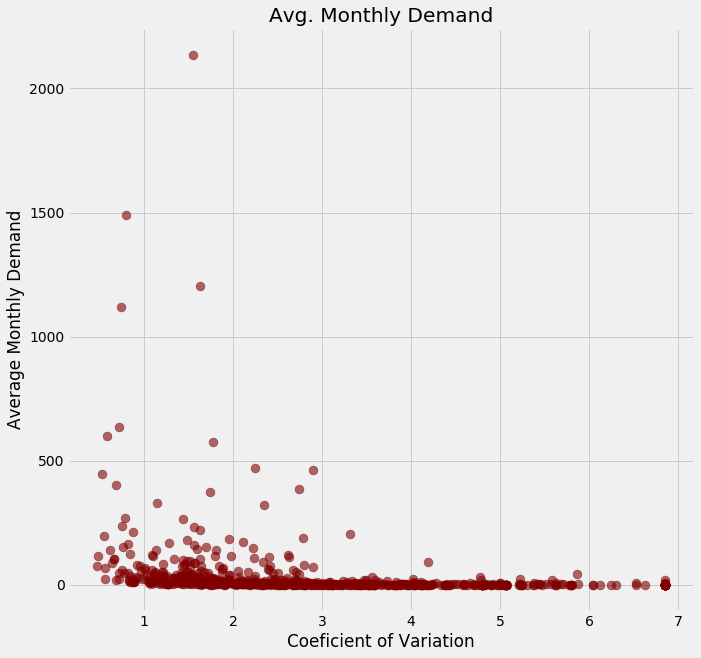

In [10]:
'''plot the data to see the spread'''
plt.style.use('fivethirtyeight')
plt.figure(figsize= (10, 10))
plt.scatter(x= cov_data['cov'], y= cov_data['avg_demand'], s= 80, alpha= 0.60, c= 'maroon')
plt.xlabel('Coeficient of Variation')
plt.ylabel('Average Monthly Demand')
plt.title('Avg. Monthly Demand')

Some quick observations. We have some Part Numbers that have really high COV and you can see that their average monthly demand is almost 0. Most Part Numbers it seems have a COV of between 1 and 3 and have higher average monthly demands. We can try visualizing this with the demand axis having a log scale. So let's plot that.

Text(0.5,1,'Avg. Monthly Demand')

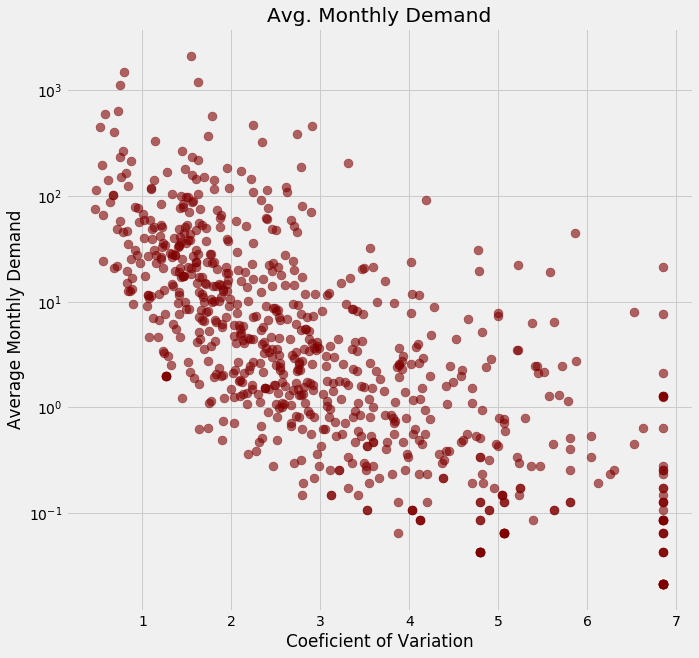

In [11]:
'''plot the data to see the spread'''

plt.figure(figsize= (10, 10))
plt.yscale('log')
plt.scatter(x= cov_data['cov'], y= cov_data['avg_demand'], s= 80, alpha= 0.60, c= 'maroon')
plt.xlabel('Coeficient of Variation')
plt.ylabel('Average Monthly Demand')
plt.title('Avg. Monthly Demand')

<h2>Handling Extreme Volatility</h2>

From our exploratory visualizations, we noticed that the COV is really high, mainly because the demand for the Part Numbers is so low in most cases. Let's try reducing the COV further by averaging the demand for each Part Number by the year.

In [12]:
'''to find out average annual demand'''
toCluster2= toCluster.copy()

'''create a year column'''
toCluster2['year']= toCluster['month'].apply(lambda x: x.year)

'''drop the month column'''
toCluster2= toCluster2.drop(['month'], axis= 1)

'''groupby year'''
toCluster2= pd.DataFrame(toCluster2.groupby(['Part Number', 'year'])['value'].sum()).reset_index()

cov_data2= toCluster2.groupby('Part Number')['value'].agg({'avg_demand':'mean',\
                                               'std_dev': 'std'}).reset_index()

cov_data2['cov']= cov_data2['std_dev'] / cov_data2['avg_demand']

/Users/adityakamath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  del sys.path[0]


Text(0.5,1,'Avg. Annual Demand (Log Scale)')

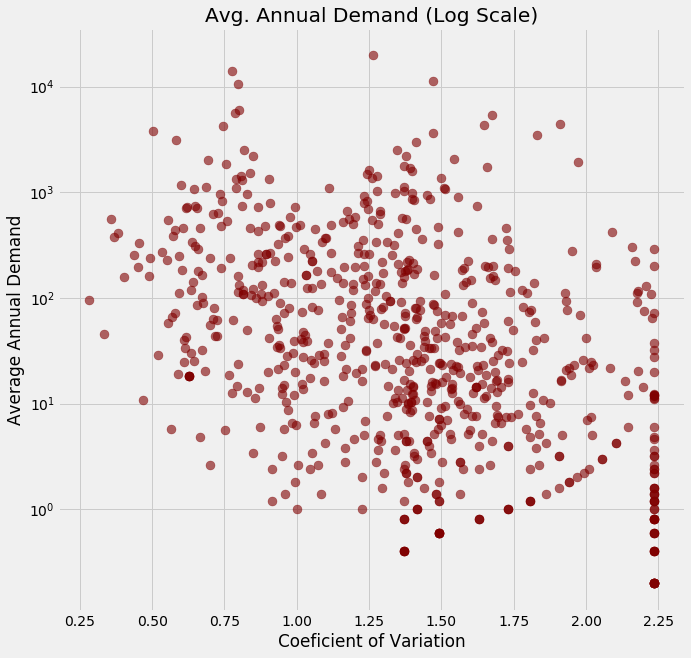

In [13]:
'''plot the data to see the spread'''
plt.style.use('fivethirtyeight')
plt.figure(figsize= (10, 10))
plt.scatter(x= cov_data2['cov'], y= cov_data2['avg_demand'], s= 80, alpha= 0.60, c= 'maroon')
plt.yscale('log')
plt.xlabel('Coeficient of Variation')
plt.ylabel('Average Annual Demand')
plt.title('Avg. Annual Demand (Log Scale)')


<h2>Data Preprocessing</h2>

Looking at the scatter plot above it is clear that our transformation has reduced the COV of the demand data. Also, since the data looks much better dispersed on the log scale, lets just create a new column in our data set with the natural log of the demand data. We're nearly ready to try our clustering approaches but we need to perform an important data preprocessing step called scaling. The Min-Max Scaling approach ensures that the range of the data is between 0 and 1. Scaling and other technicques such as Normalizing are often used to prepare the features of the data (predictors) for machine learning. More on this in the references below. So let's do the following two things:

• The demand data looks much better dispersed on the log scale so create a new column with the natural log of the average  yearly demand.

• Use the 'preprocessing' feature to scale both the average yearly demand data and the COV data.

In [14]:
'''storing log values of the annual demand for each SKU'''
cov_data3= cov_data2.copy()
cov_data3['log_demand']= cov_data3['avg_demand'].apply(lambda x: np.log(x))

In [15]:
'''normalize both the log of annual demand as well as the COV'''
'''min max scaler can be only applied on numpy arrays and then reshaping them...this is as per the recently updated package'''
min_max_scaler = preprocessing.MinMaxScaler()
cov_data3['cov_scaled']= min_max_scaler.fit_transform(cov_data3['cov'].values.reshape(-1,1))
cov_data3['demand_scaled']= min_max_scaler.fit_transform(cov_data3['log_demand'].values.reshape(-1,1))

Text(0,0.5,'Average Annual Demand (Log)')

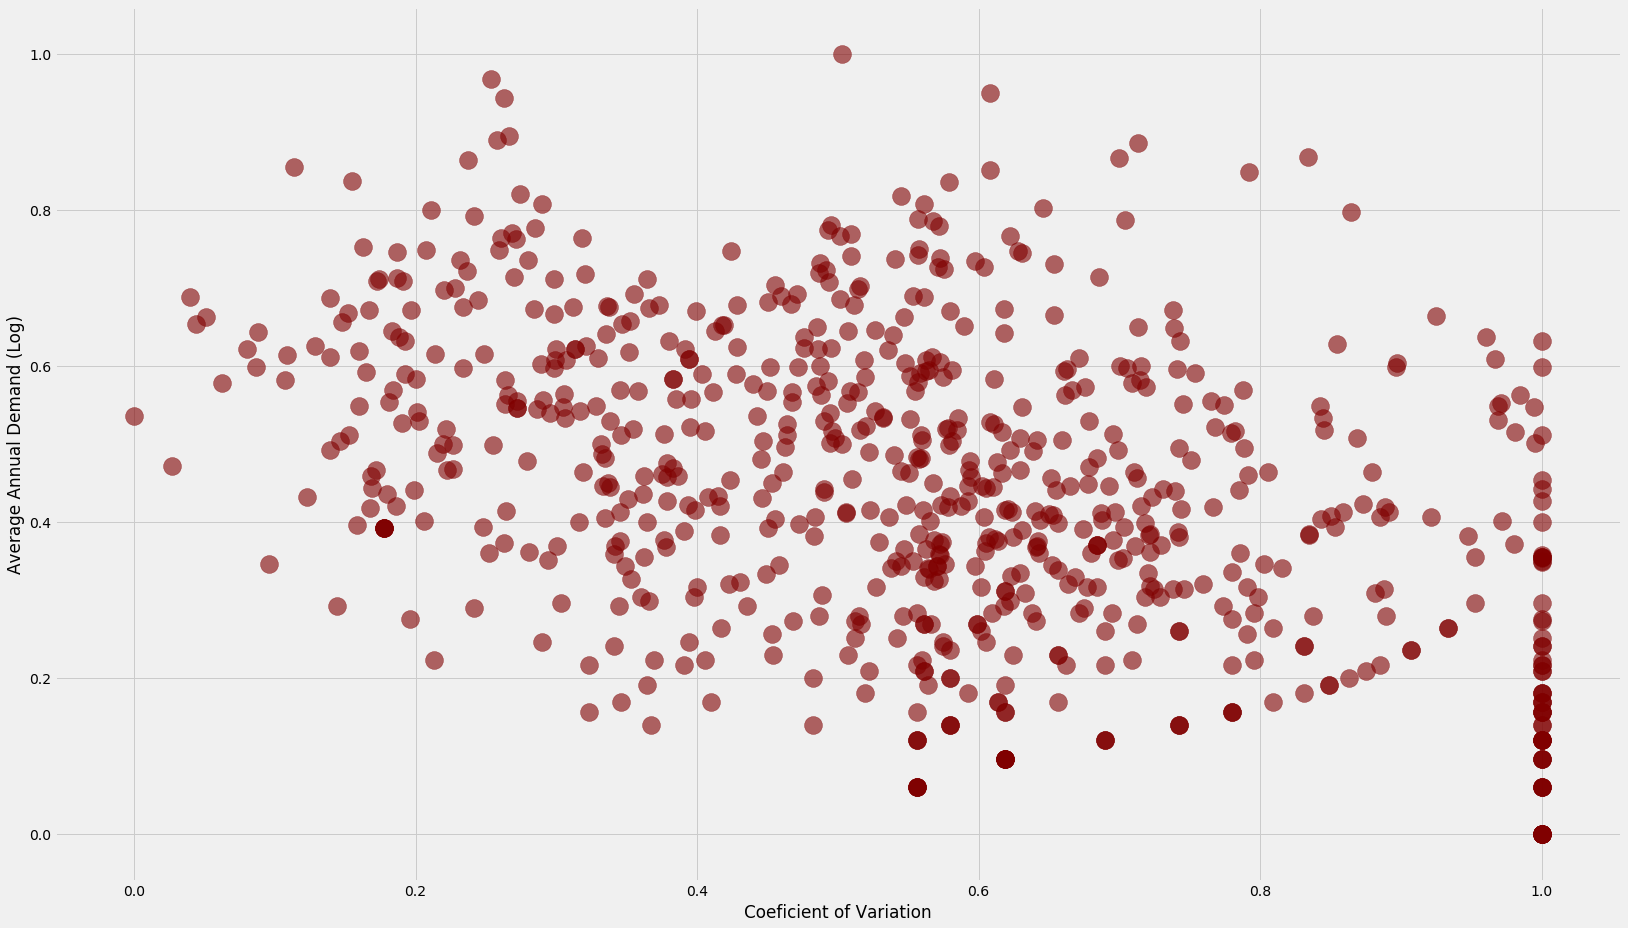

In [16]:
'''plot the data to see the spread'''
plt.style.use('fivethirtyeight')
plt.figure(figsize= (25, 15))
plt.scatter(x= cov_data3['cov_scaled'], y= cov_data3['demand_scaled'], s= 320, alpha= 0.60, c= 'maroon')
plt.xlabel('Coeficient of Variation')
plt.ylabel('Average Annual Demand (Log)')


<h3>Hierarchical Agglomerative Clustering</h3>

We will not delve into the details of how these clustering algorithms work instead we will briefly look at the results of applying these algorithms on our dataset. The first clustering algorithm we'll try is called Agglomerative Clustering or Hierarchical Agglomerative Clusterting (HAC). It begins clustering with one cluster containing all the data points and then works its way hierarchically by splitting each cluster until it reaches the individual data points. The best way to visualize this is through a dendrogram that you can see below. Each branch that you see is one cluster and the very bottom are the data points, the Part Numbers that belong to that cluster. HAC doesn't prescribe the best number of clusters so we will arbitrarily provide it a value. In this case, I've specified it as 6 by looking at the dendrogram but an online search on this topic will show you some heuristics that you can use to find the best number of clusters.

Text(0.5,0,'Coefficient of Variance')

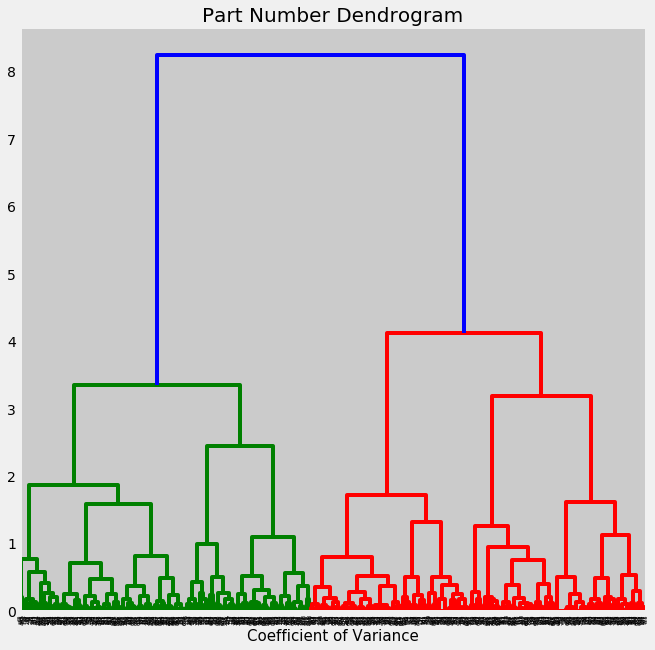

In [17]:
'''clsutering starts here'''
fig = plt.figure(figsize=(10,10))
Y= cov_data3.iloc[:, [6,5]].values
dendrogram= sch.dendrogram(sch.linkage(Y, method= 'ward'))
plt.title('Part Number Dendrogram', fontsize= 20)
plt.xlabel('Coefficient of Variance', fontsize= 15)


In [18]:
'''fitting the hierarchical clustering model to the dataset'''
from sklearn.cluster import AgglomerativeClustering
hc= AgglomerativeClustering(n_clusters= 6, affinity= 'euclidean', linkage= 'ward')
y_hc= hc.fit_predict(Y)

Text(0,0.5,'Average Annual Demand (Log)')

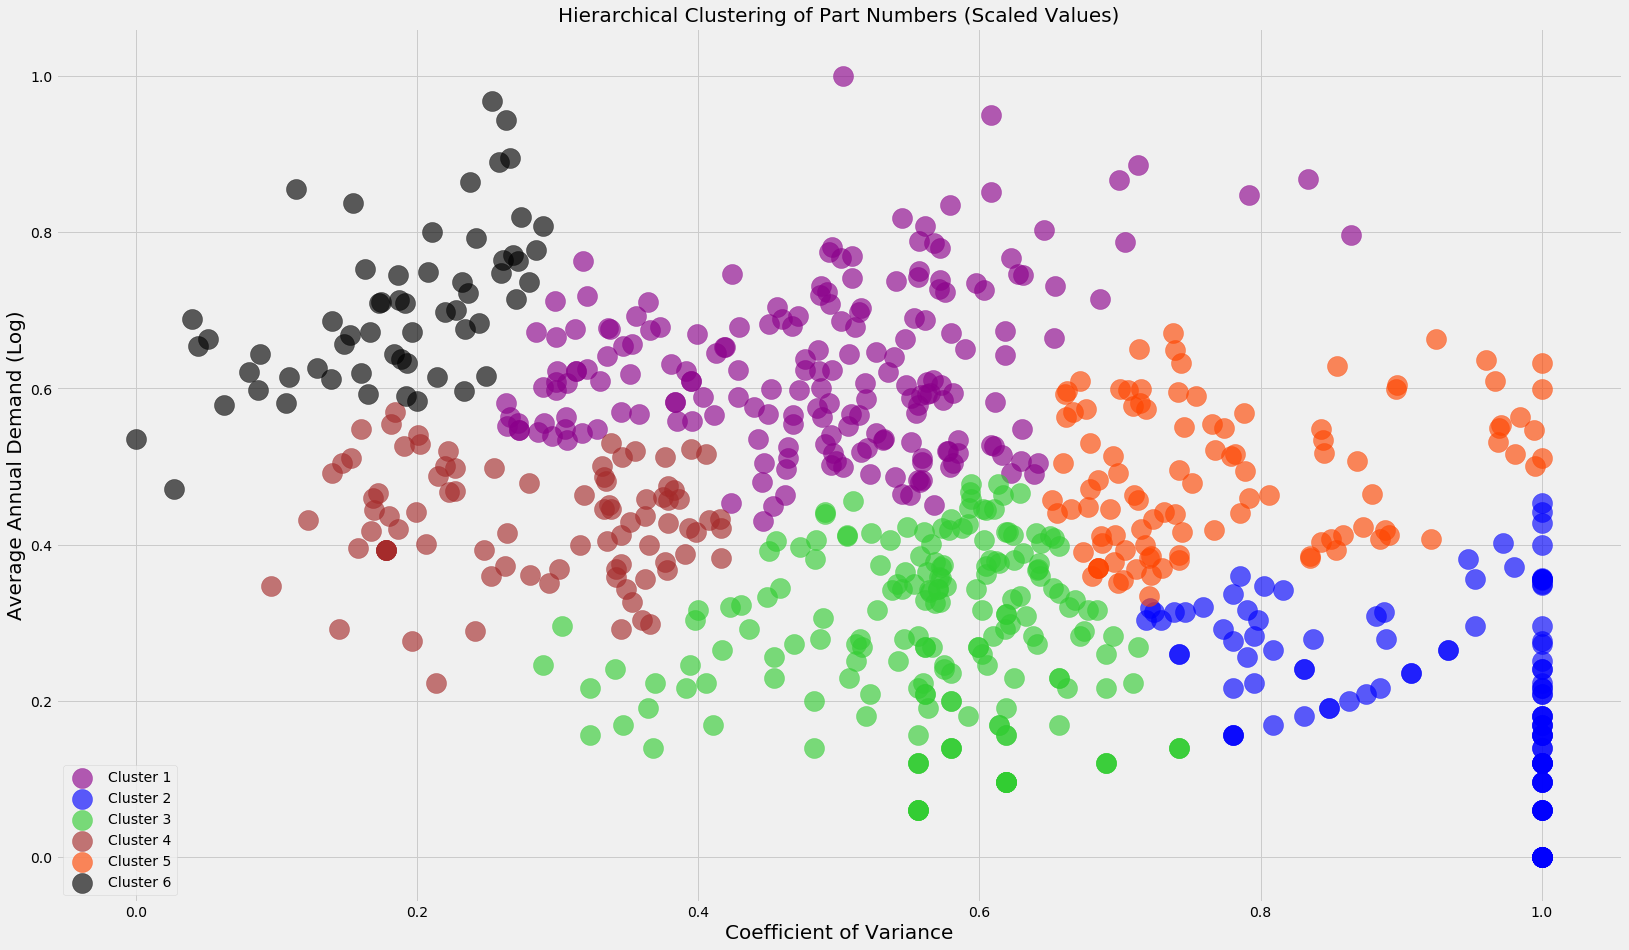

In [19]:
'''visualize the clusters'''
font = {'size'   : 35}
plt.style.use('fivethirtyeight')
plt.rc('font')
fig = plt.figure(figsize=(25,15))
plt.scatter( Y[y_hc == 0,1], Y[y_hc== 0,0], s= 400, c= 'darkmagenta', label= 'Cluster 1', alpha= 0.63)
plt.scatter( Y[y_hc == 1,1], Y[y_hc== 1,0], s= 400, c= 'blue', label= 'Cluster 2', alpha= 0.63)
plt.scatter( Y[y_hc == 2,1], Y[y_hc== 2,0], s= 400, c= 'limegreen', label= 'Cluster 3', alpha= 0.63)
plt.scatter( Y[y_hc == 3,1], Y[y_hc== 3,0], s= 400, c= 'brown', label= 'Cluster 4', alpha= 0.63)
plt.scatter( Y[y_hc == 4,1], Y[y_hc== 4,0], s= 400, c= 'orangered', label= 'Cluster 5', alpha= 0.63)
plt.scatter( Y[y_hc == 5,1], Y[y_hc== 5,0], s= 400, c= 'black', label= 'Cluster 6', alpha= 0.63)
plt.legend(loc='lower left')
plt.title('Hierarchical Clustering of Part Numbers (Scaled Values)', fontsize= 20)
plt.xlabel('Coefficient of Variance', fontsize= 20)
plt.ylabel('Average Annual Demand (Log)', fontsize= 20)


In [20]:
'''Now that we've got the results of the clustering, let's add a column of the cluster labels back to the original dataset'''
data_agglomerative= cov_data3.copy()
data_agglomerative['hierarchical_cluster']= y_hc

In [21]:
'''preview the cluster labels'''
data_agglomerative.head(3)

,Part Number,avg_demand,std_dev,cov,log_demand,cov_scaled,demand_scaled,hierarchical_cluster
0,PN-100-430,14.0,23.409400,1.672100,2.639057,0.711461,0.368888,4
1,PN-101-146,561.4,662.566072,1.180203,6.330434,0.459795,0.689403,0
2,PN-101-855,1610.4,2010.917900,1.248707,7.384238,0.494843,0.780903,0


From the results, we can see how the algorithm has clusterred the data. Some clusters with a smaller range of COV are more compact while those clusters at the farther end of the COV axis are more spread out. Let's try another clustering algorithm to see the results. 

<h3>K-Means Clustering</h3>

A very popular clustering approach, the K-Means algorithm clusters the data around 'k' centroids that we define. The algorithm first chooses 'k' centroids randomly and then forms clusters by assigning those data points that are closest to a centroid. It then calculates new centroids for each cluster and then again assigns data points to clusters formed by the new centroids. Ultimately if the centroids don't change, the algorithm stops. Here too, the algorithm will not decide the number of centroids so you have to choose them. One popular method is called the Elbow method. Elbow method compares the Sum of Squared Error versus the number of centroids. Essentially, higher the number of centroids, lower is the SSE, but then we don't want too many cetnroids either. So we choose 'k' where the curve forms an elbow. 

In [22]:
'''create a copy of the data'''
data_kmeans= cov_data3.copy()

In [23]:
'''create a list with the range of clusters to be tested'''
Ks = range(5, 40)

'''create a separate list with K-Means objects stored for each cluster size'''
km = [KMeans(n_clusters=i) for i in Ks]

'''create another list to store the clustering scores for each cluster size'''
score = [km[i].fit(data_kmeans[['cov_scaled', 'demand_scaled']]).score(data_kmeans[['cov_scaled', 'demand_scaled']]) for i in range(len(km))]

'''since the scores are negative, create a new list with positive scores'''
score2 = [x* -1 for x in score]

Text(0,0.5,'K-Means Score')

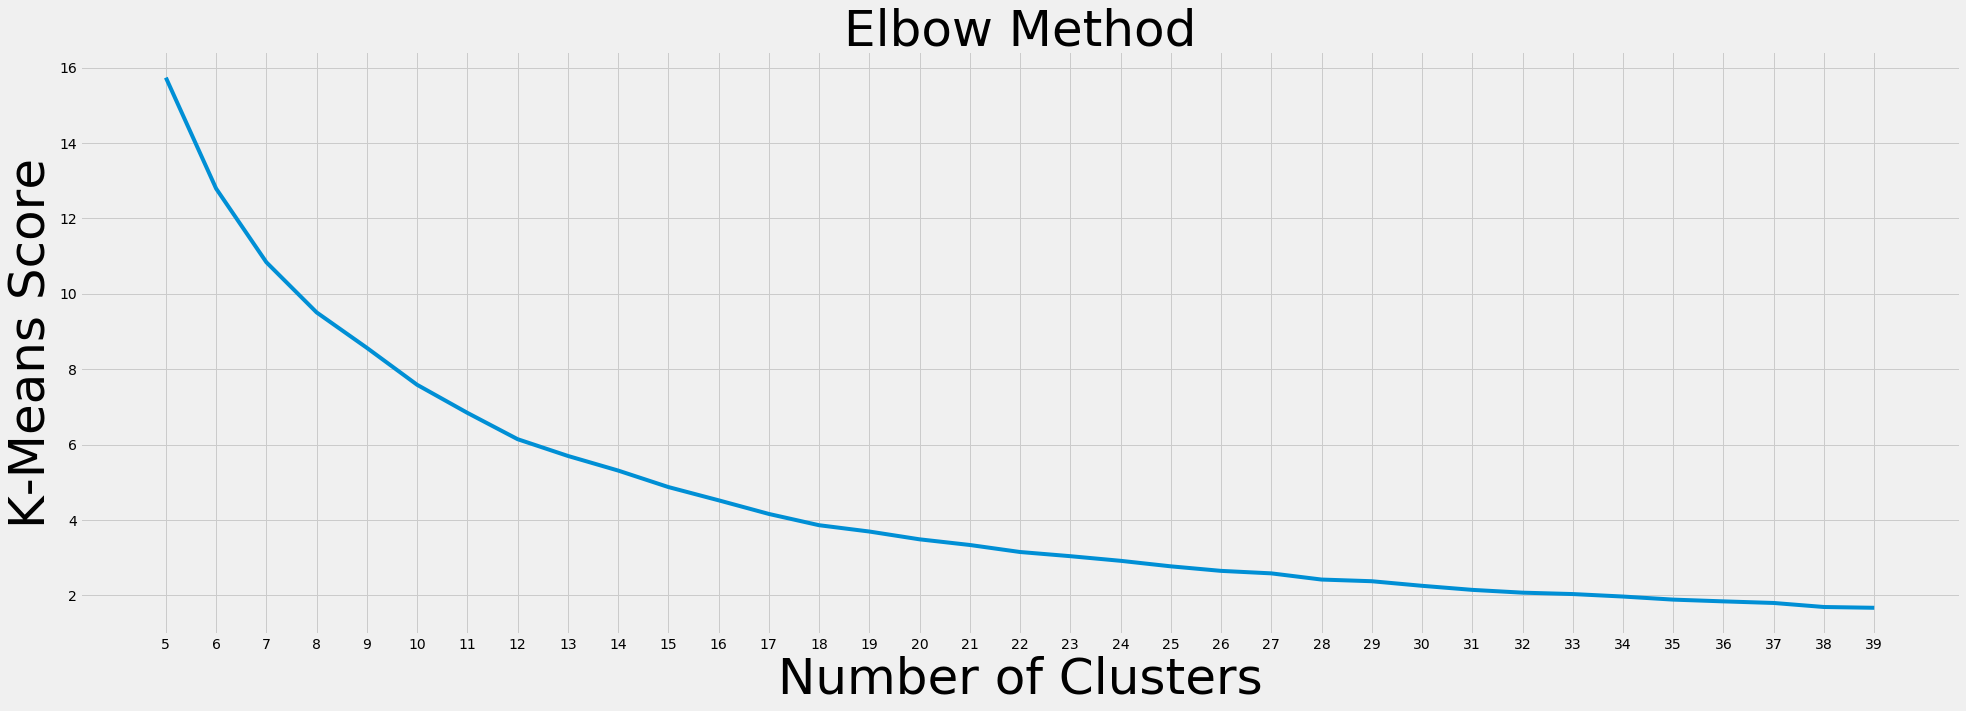

In [24]:
'''create the Elbow Plot'''

plt.style.use('fivethirtyeight')
plt.figure(figsize= (30,10))
plt.plot(Ks, score2)
plt.title('Elbow Method', fontsize= 50)
plt.xlabel('Number of Clusters', fontsize= 50)
plt.xticks(range(5, 40, 1))
plt.ylabel('K-Means Score', fontsize= 50)

From the plot above, its not very clear where the elbow forms. And so the Elbow Method is not always effective. There are other ways you can find the optimum number of centroids like the Silhoutte Method, but we will not explore them in this post. See the references for more information. For this post, let's select k= 12 and run the K-Means algorithm.

In [25]:
'''applying the K-Means algorithm by creating a M-Means object and then fitting the object to the data'''

clustering= KMeans(n_clusters= 12, random_state= 5).fit(data_kmeans[['cov_scaled', 'demand_scaled']])

In [26]:
'''store the clsuter labels in the dataframe'''
data_kmeans['kmeans_cluster']= clustering.labels_

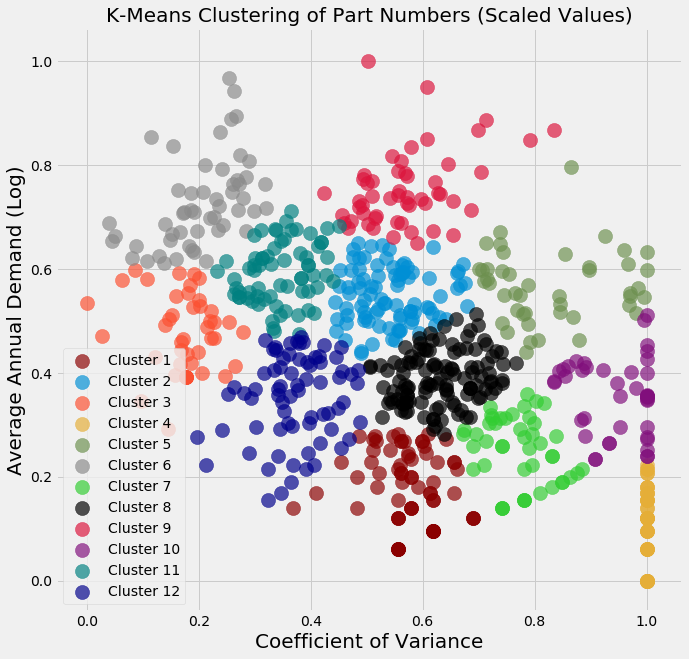

In [31]:
'''plot the results of the K-Means clustering with 7 clusters as found from elbow method'''

plt.style.use('fivethirtyeight')
plt.figure(figsize= (10, 10))
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 0]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 0]['demand_scaled'].values , label= 'Cluster 1', s= 200, alpha= 0.68, c= 'darkred')
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 1]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 1]['demand_scaled'].values , label= 'Cluster 2', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 2]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 2]['demand_scaled'].values , label= 'Cluster 3', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 3]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 3]['demand_scaled'].values , label= 'Cluster 4', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 4]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 4]['demand_scaled'].values , label= 'Cluster 5', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 5]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 5]['demand_scaled'].values , label= 'Cluster 6', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 6]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 6]['demand_scaled'].values , label= 'Cluster 7', s= 200, alpha= 0.68, c= 'limegreen')
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 7]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 7]['demand_scaled'].values , label= 'Cluster 8', s= 200, alpha= 0.68, c= 'black')
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 8]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 8]['demand_scaled'].values , label= 'Cluster 9', s= 200, alpha= 0.68, c= 'crimson')
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 9]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 9]['demand_scaled'].values , label= 'Cluster 10', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 10]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 10]['demand_scaled'].values , label= 'Cluster 11', c= 'teal', s= 200, alpha= 0.68)
plt.scatter(x=data_kmeans[data_kmeans['kmeans_cluster'] == 11]['cov_scaled'].values , y=data_kmeans[data_kmeans['kmeans_cluster'] == 11]['demand_scaled'].values , label= 'Cluster 12', s= 200, alpha= 0.68, c= 'darkblue')

plt.title('K-Means Clustering of Part Numbers (Scaled Values)', fontsize= 20)
plt.xlabel('Coefficient of Variance', fontsize= 20)
plt.ylabel('Average Annual Demand (Log)', fontsize= 20)
plt.legend(loc='lower left')


In [28]:
'''look at the labels in the dataset'''
data_kmeans.head(3)

,Part Number,avg_demand,std_dev,cov,log_demand,cov_scaled,demand_scaled,kmeans_cluster
0,PN-100-430,14.0,23.409400,1.672100,2.639057,0.711461,0.368888,7
1,PN-101-146,561.4,662.566072,1.180203,6.330434,0.459795,0.689403,8
2,PN-101-855,1610.4,2010.917900,1.248707,7.384238,0.494843,0.780903,8


In [29]:
'''write the results to excel files'''
data_kmeans.to_excel('kmeans_results.xlsx', index= False)
data_agglomerative.to_excel('hierarchical_results.xlsx', index= False)

<h2>What's Next?</h2>

We've reached the end of this blog post, having explored two clustering approaches in trying to solve a supply chain business case. In the process, we performed some data wrangling and preprocessing to prepare the data for clustering and also briefly looked at different ways of improving the clustering results. This analysis is by no means complete and you could explore different evaluation methods to see how effective the clusters that we've created are. The clusters are nothing but product families and the next step in the analysis pipleine might be forecasting demand for these families. So a natural question that arises is how does the type of clustering algorithm affect the 'forecastability' of your product families? Let me know what you think!

<h2>References</h2>

- Ben Alex Keen On Feature Scaling: http://benalexkeen.com/feature-scaling-with-scikit-learn/
- George Seif On Custering: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68
- K-Means Clustering: https://www.youtube.com/watch?v=ikt0sny_ImY
- Hierarchical Agglomerative Clustering: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/